# S Parameters

Scattering (S) parameters describe the relationship between signals entering through the ports of a device and the signals exiting from those same ports.
They are usually represented as a frequency-dependent matrix and are used to build compact models of devices in photonics, microwaves, RF, etc.
In PhotonForge, the S parameters are stored as a sparse matrix in a python dictionary, as we'll see in this guide.

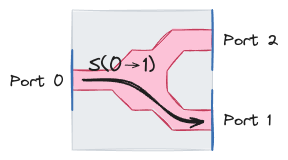

Computation of the S matrix in PhotonForge is done via [models](../models.rst), which makes it very flexible to accommodate use cases ranging from purely analytical calculations, to [FDTD](Tidy3D_Model.ipynb), or measured data.
This guide shows how the S matrix computed in PhotonForge can be used for visualization and further post-processing.

## Computing The S Matrix

We will [load](PDK_Components.ipynb) the Y splitter from the [SiEPIC OpenEBL](https://siepic.ca/openebl/) PDK.
It includes a [Tidy3D model](../_autosummary/photonforge.Tidy3DModel.rst) that will leverage the power of Tidy3D to calculate the S matrix of this component using full 3D FDTD simulations.

In [1]:
import numpy as np
import photonforge as pf
import siepic_forge as siepic
from matplotlib import pyplot as plt

# Set the SiEPIC technology as default in this project
pf.config.default_technology = siepic.ebeam()

In [2]:
y_splitter = siepic.component("ebeam_y_1550")
y_splitter

The actual S matrix computation requires only the specification of the simulation frequencies in the [s_matrix](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) function:

In [3]:
wavelengths = np.linspace(1.5, 1.6, 11)
freqs = pf.C_0 / wavelengths

s_matrix = y_splitter.s_matrix(freqs)

Starting...
Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-HYJWZ7JSZDWU2TUCTBCVHUOK3RINJD32Z4SFSGJA3ZOS7JYSORQQ.json.


Loading cached simulation from .tidy3d/pf_cache/W34/fdtd_info-LZFSWC33JTHH3XYGRDZB7KHXCEELMNU22DZ2WQ6FP7JJKUMUDOZA.json.
Progress: 100% 


Despite the name, the returned `s_matrix` object is not a matrix, but an [SMatrix](../_autosummary/photonforge.SMatrix.rst) instance.
It stores the usual S matrix elements in a dictionary and also the frequencies and ports used for the computation.

Using a dictionary instead of a multidimensional array for the elements not only alleviates memory usage in large and sparse systems, but also facilitates using port names instead of integer indices to identify the matrix elements.
In this dictionary, each key is a pair of port names and mode index: `(input_port_and_mode, output_port_and_mode)`.
Note that this departs from the index order in electromagnetic theory, where $S_{ij}$ represents input at $j$-th port and output at the $i$-th port.

In [4]:
s_matrix.elements.keys()

dict_keys([('P2@0', 'P0@0'), ('P2@0', 'P1@0'), ('P0@0', 'P0@0'), ('P0@0', 'P1@0'), ('P0@0', 'P2@0'), ('P1@0', 'P0@0'), ('P2@0', 'P2@0'), ('P1@0', 'P1@0'), ('P1@0', 'P2@0')])

The port names and mode indices are joined in the `s_matrix` keys with an "@" character.
Because the ports used in the Y splitter are all single mode, we only have mode index 0 in our keys.

We look at the complex transmission coefficient from "P0" to "P1" for the fundamental mode: it is a Numpy array with one coefficient for each frequency/wavelength point we specified earlier.

In [5]:
s_matrix[("P0@0", "P1@0")]

array([-0.54708849-0.41812651j, -0.3155284 +0.61499624j,
        0.65859863+0.2163347j ,  0.12619265-0.68275873j,
       -0.6931858 -0.04881663j,  0.01441391+0.69509133j,
        0.69224108-0.06279949j, -0.09594949-0.68799921j,
       -0.68494714+0.11420323j,  0.11833159+0.68405245j,
        0.68521835-0.10839434j])

We can look at the magnitude squared of those elements to get the power transmission coefficients:

In [6]:
np.abs(s_matrix[("P0@0", "P1@0")]) ** 2

array([0.4741356 , 0.47777854, 0.48055286, 0.48208407, 0.48288962,
       0.48335972, 0.48314149, 0.48254922, 0.48219496, 0.48193011,
       0.48127352])

## Visualization and Post-Processing

Post-processing and visualization is as easy as working with any Numpy arrays.
For example, we can calculate the insertion loss for port P0 by subtracting the power transmission coefficients to the other ports from 1:

In [7]:
trans1 = np.abs(s_matrix[("P0@0", "P1@0")]) ** 2
trans2 = np.abs(s_matrix[("P0@0", "P2@0")]) ** 2

insertion_loss = 1 - trans1 - trans2
insertion_loss

array([0.05169102, 0.04440769, 0.03886142, 0.03580019, 0.03418967,
       0.03324959, 0.03368901, 0.03487861, 0.03558857, 0.03611539,
       0.03742644])

Plotting is just as easy too:

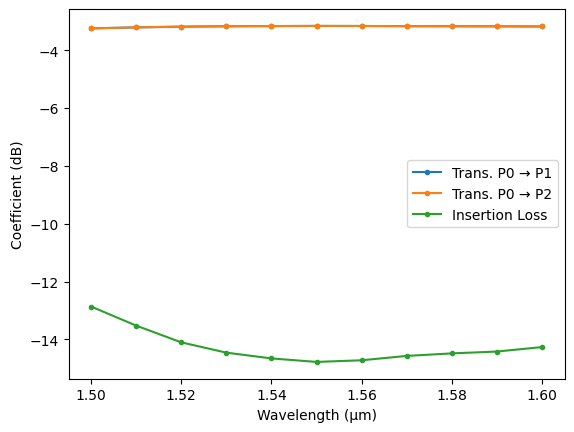

In [8]:
_, ax = plt.subplots(1, 1)

ax.plot(wavelengths, 10 * np.log10(trans1), ".-", label="Trans. P0 → P1")
ax.plot(wavelengths, 10 * np.log10(trans2), ".-", label="Trans. P0 → P2")
ax.plot(wavelengths, 10 * np.log10(insertion_loss), ".-", label="Insertion Loss")

ax.set(xlabel="Wavelength (μm)", ylabel="Coefficient (dB)")
_ = ax.legend()

For quick visualization, PhotonForge includes the [plot_s_matrix](../_autosummary/photonforge.plot_s_matrix.rst) function, which can be customized to some extend to inspect the S matrix.

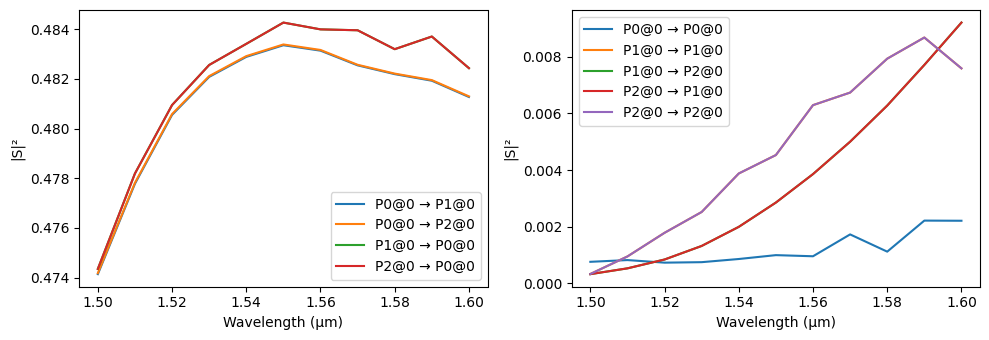

In [9]:
_ = pf.plot_s_matrix(s_matrix)

We can limit the number of input and output ports to plot, change the plot value, scale, etc.

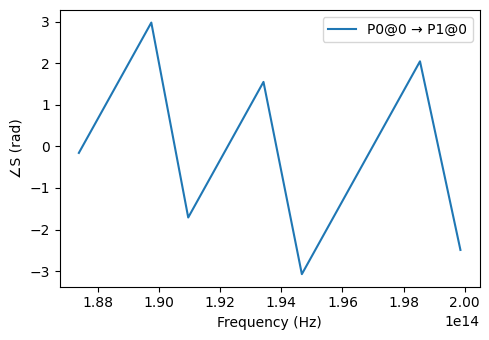

In [10]:
_ = pf.plot_s_matrix(s_matrix, x="frequency", y="phase", input_ports=["P0"], output_ports=["P1"])